# 2022 EY Data Science Challenge - Level 1

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="files/frogs/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

In this notebook, we will demonstrate a basic model workflow that can act as a starting point for the challenge. As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. In this demonstation, we will be using four features from the TerraClimate dataset, the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture, and will train a logistic regression model with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


Most of the functions present in this notebook were adapted from the following notebooks:
- [Training Dataset Summary](supplementary_notebooks/dataset_summary.ipynb)
- [TerraClimate/Weather](supplementary_notebooks/TerraClimate.ipynb)

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think are best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


## Load in dependencies

To run this demonstration notebook, you will need to have the following packages installed. The full list of packages can be found in 'data/requirements.txt' which can be installed with conda by running `!conda install requirements.txt` in a new Jupyter cell.

In [36]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
from itertools import cycle

# Folder to store extracted files
storage_path = './files/output/'

# Path to data folder with provided material
data_path = '../data/'

## Response Variable

Before we can build our model, we need to load in the response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [8]:
if not os.path.exists(data_path+'/training_data/'):
    os.mkdir(data_path+'/training_data/')
    with zipfile.ZipFile(data_path+'/0128886-210914110416597.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'/training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    frogs = (
        pd.read_csv(file, sep='\t', parse_dates=['eventDate'])
        # Take relevent columns
        [['gbifID','eventDate','countryCode','decimalLatitude',
          'decimalLongitude','species','verbatimScientificName']]
        [lambda x: (~x.decimalLatitude.isna()) & (~x.decimalLongitude.isna())]
        [lambda x: (x.decimalLatitude != 0.0) & (x.decimalLongitude != 0.0)]
        .assign(
            country =  lambda x: x.countryCode.map(
                {'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa'}
            ),
            species =  lambda x: x.verbatimScientificName.str.title()
        )
        .drop(['verbatimScientificName', 'countryCode'], 1)
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

For this demonstration, we will constrain our search to frogs in the Greater Sydney area found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

You are encouraged to explore different areas to assist in creating a SDM that is representative of the habitat of litoria fallax, but keep in mind that loading in large areas may be quite computationally expensive. 

In [9]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,decimalLatitude,decimalLongitude,species,country
1489,1453288375,2016-12-07 17:09:00,-34.130907,150.603024,Litoria Fallax,Australia
2017,3108864037,2019-01-02 00:00:00,-33.703979,150.301906,Crinia Signifera,Australia
2021,3108854306,2019-10-07 00:00:00,-33.709317,150.598369,Litoria Fallax,Australia
2024,3108868567,2019-06-15 00:00:00,-33.778650,151.017143,Crinia Signifera,Australia
2041,1452174079,2015-08-26 00:00:00,-33.989385,150.845131,Crinia Signifera,Australia
...,...,...,...,...,...,...
146087,3108929443,2017-11-27 00:00:00,-33.713989,150.907502,Litoria Fallax,Australia
146089,1916697998,2017-02-08 00:00:00,-33.841557,151.072879,Litoria Fallax,Australia
146099,3108949628,2019-11-04 00:00:00,-33.756196,150.623293,Litoria Fallax,Australia
146114,1916176618,2017-10-29 00:00:00,-33.850554,150.631370,Crinia Signifera,Australia


Below we define some functions to assist in plotting the frog data. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [10]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area. Here, only two of the five Australian species are present: crinia signifera, the common eastern froglet, and litoria fallax, the eastern dwarf tree frog.

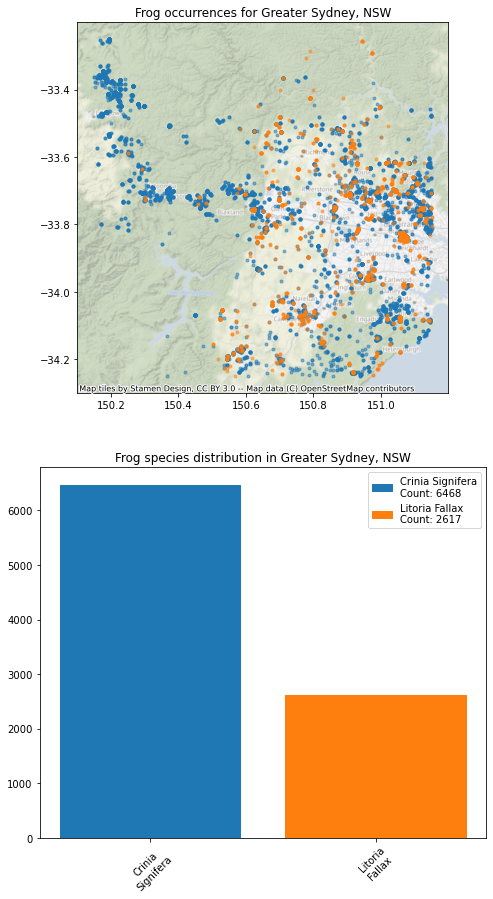

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

### Sampling bias

One method of addressing the sampling bias inherent in the database is to focus on predicting one species, and to use the occurrence points of other species as absence points. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will attempt to predict the second most common species in the area, litoria fallax - the eastern dwarf tree frog, while using the other species, crinia signifera - the common eastern froglet, as examples of its absence. Litoria fallax is pictured below:

![Litoria_fallax](files/frogs/Litoria_fallax.jpg)

In [12]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0),
        key = all_frog_data.index
    )
)
all_frog_data

,gbifID,eventDate,decimalLatitude,decimalLongitude,species,country,occurrenceStatus,key
1489,1453288375,2016-12-07 17:09:00,-34.130907,150.603024,Litoria Fallax,Australia,1,1489
2017,3108864037,2019-01-02 00:00:00,-33.703979,150.301906,Crinia Signifera,Australia,0,2017
2021,3108854306,2019-10-07 00:00:00,-33.709317,150.598369,Litoria Fallax,Australia,1,2021
2024,3108868567,2019-06-15 00:00:00,-33.778650,151.017143,Crinia Signifera,Australia,0,2024
2041,1452174079,2015-08-26 00:00:00,-33.989385,150.845131,Crinia Signifera,Australia,0,2041
...,...,...,...,...,...,...,...,...
146087,3108929443,2017-11-27 00:00:00,-33.713989,150.907502,Litoria Fallax,Australia,1,146087
146089,1916697998,2017-02-08 00:00:00,-33.841557,151.072879,Litoria Fallax,Australia,1,146089
146099,3108949628,2019-11-04 00:00:00,-33.756196,150.623293,Litoria Fallax,Australia,1,146099
146114,1916176618,2017-10-29 00:00:00,-33.850554,150.631370,Crinia Signifera,Australia,0,146114


### Class Balancing

Clearly, there is quite a large class imbalance here. To handle this, we will down-sample the non-target species frogs so that their numbers match that of the target species. Note that this is quite a naive approach as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. This may not be ideal, as these isolated occurrences are often the most important data points available for frog conservationists. Developing a smarter sampling method may be a worthwhile pursuit when considering ways to improve your model.

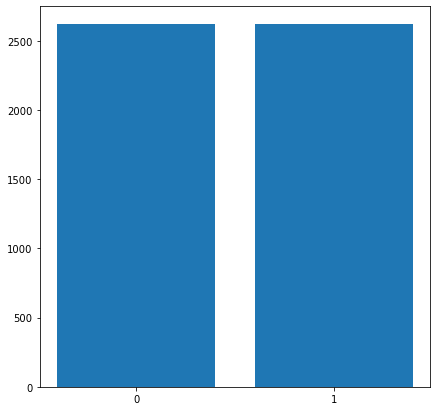

In [13]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]

frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
)

fig, ax = plt.subplots(figsize=(7, 7))

bar_data = frog_data.occurrenceStatus.value_counts()
barchart = ax.bar(bar_data.index.astype(str), bar_data)

After balancing the classes, we finally have our training data visualised below. Again, it must be stressed that this is just one way of addressing the sampling bias inherent in the GBIF data and it does not address the bias completely. Since we will be using this training dataset for evaluation, the evaluation metrics will also contain bias. You are encouraged to improve the training set collection process, particularly the frog absence sampling, until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.


Since we will be using this training dataset for evaluation, the evaluation metrics will contain bias due to our naive approaches to addressing each of the above issues. You are encouraged to improve the training set collection process until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.


Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

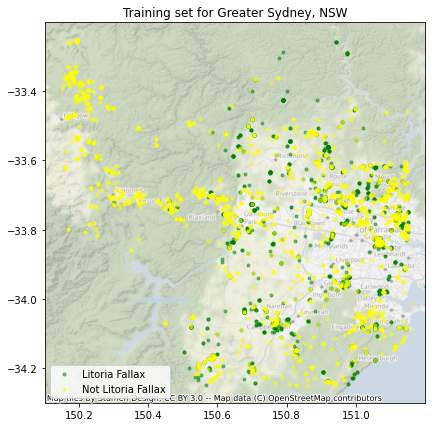

In [15]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

### Getting Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables. Code in this section is adapted from the [Weather](Weather.ipynb) notebook.

#### Fetching TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an $(n\times m)$ image. We will choose $(512\times 512)$.


In [16]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [17]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

#### Visualising the TerraClimate Data

The spatial distribution of the four variables are displayed below.

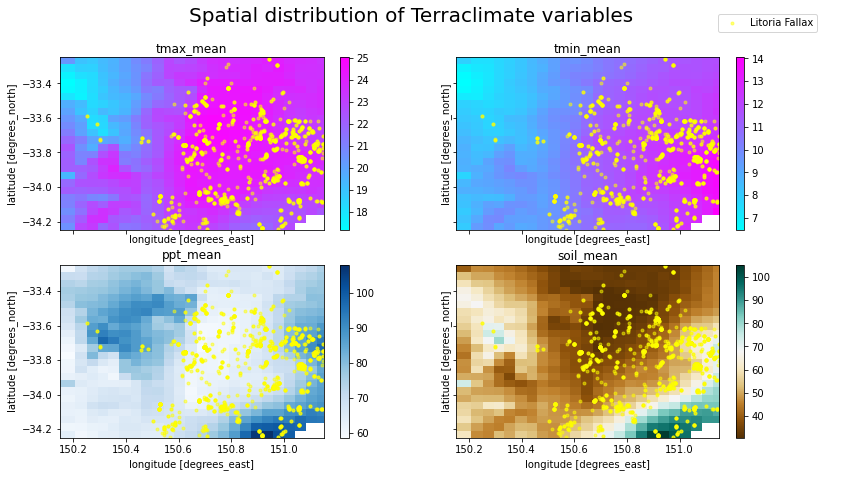

In [18]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

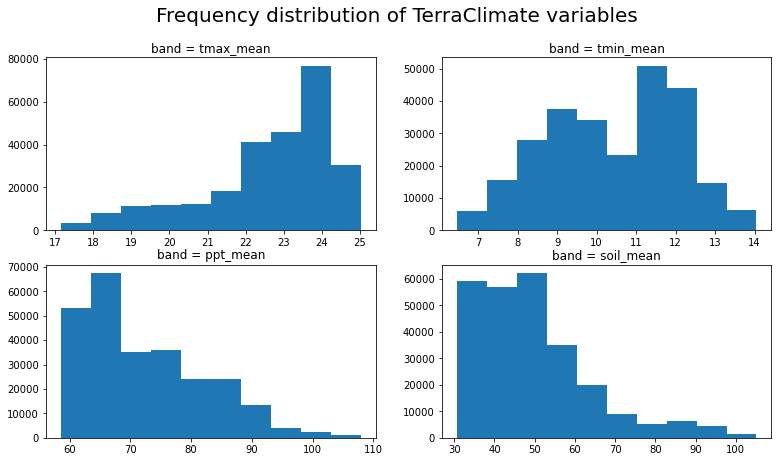

In [19]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)
# fig.legend(loc=(0.85, 0.933))

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [20]:
def join_features(model_data, predictor_image):
    """Joins the features from each feature dataset onto each response variable. 

    Arguments:
    model_data -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    all_datasets -- list of feature datasets stored as xarray dataarrays, indexed with geocoordinates
    """
    # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
    data_per_point = pd.DataFrame()
    for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
        # Print out some progress markers
        if (j+1)%(len(model_data)//10)==0:
            print(f"{j+1} of {len(model_data)}")

        # Get the predictor pixel at the site of the frog occurrence
        nearest_point = predictor_image.sel(y=lat, x=lon, method="nearest")

        # Prepare values and columns and save them in a dataframe, saving the join key for later reference
        values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
        columns = list(nearest_point.band.values) + ['key']
        data_per_point = data_per_point.append(
            pd.DataFrame(
                np.array([values]), 
                columns=columns
            )
        )

    # Join the predictor variables we just collected back onto the frog data
    model_data = model_data.merge(
        data_per_point,
        on = ['key'],
        how = 'inner'
    )
        
    return model_data

model_data = join_features(frog_data, weather_data)
model_data.head()

523 of 5234
1046 of 5234
1569 of 5234
2092 of 5234
2615 of 5234
3138 of 5234
3661 of 5234
4184 of 5234
4707 of 5234
5230 of 5234


,gbifID,eventDate,decimalLatitude,decimalLongitude,species,country,occurrenceStatus,key,tmax_mean,tmin_mean,ppt_mean,soil_mean
0,2960451933,2018-09-13,-33.688100,151.092000,Crinia Signifera,Australia,0,128978,22.998333,12.290002,89.733330,66.099998
1,3108902053,2018-12-19,-33.614559,151.040300,Crinia Signifera,Australia,0,74202,23.305002,11.830001,79.033333,49.400002
2,2421024174,2019-02-15,-33.840416,151.070440,Crinia Signifera,Australia,0,74833,23.933336,13.291668,73.933334,56.266666
3,2960468959,2019-09-25,-34.060445,151.079497,Crinia Signifera,Australia,0,117089,22.936670,12.831668,85.533333,83.699997
4,2556827512,2018-04-30,-33.811659,150.658943,Crinia Signifera,Australia,0,108358,24.278332,11.053333,63.083332,36.500000


### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [21]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will generalise to areas other than the training sight. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for the training area.

In [22]:
full_model.fit(X, y)

LogisticRegression()

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model.

In [23]:
predictions = full_model.predict(X)

#### Predict Entire Region

We also want to perform predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region.

In [24]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### Results

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

Now that we have our model predictions for the training set stored in the `predictions` variable, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook made no effort to address this. The model evaluation metrics are only as good as the test data, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance.

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation. You can even code your own if you think it will assist you in evaluating your model.


In [25]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.68
Accuracy: 0.65


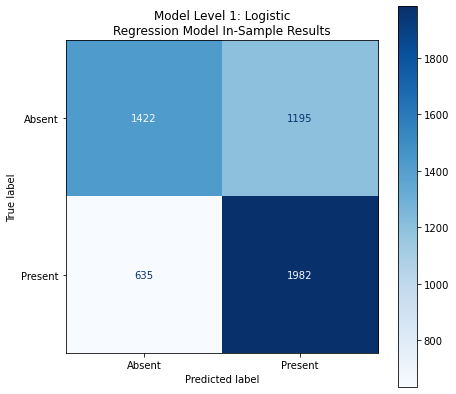

In [26]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

From above, we see that the model is able to achieve an ok F1 score and accuracy. From the confusion matrix, we can see that our model is pretty balanced in its false positives and false negatives. These are both good signs, but clearly there is plenty of room for improvement.

`Should ask frog experts about the cost matrix - are false negatives more costly for conservation efforts than false positives?`


#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly.

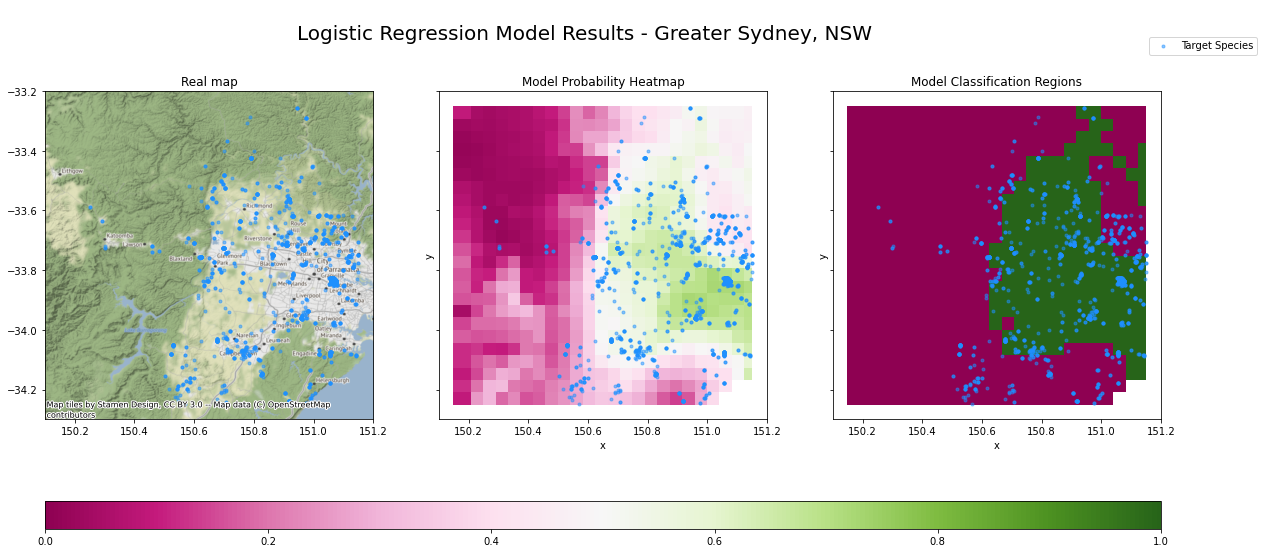

In [27]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    
    cmap = 'PiYG'

    
    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")

From the plots above, we can confirm the accuracy metrics which suggested the model does an ok job of predicting the habitats of litoria fallax against the other species. The main limitation of this model is the coarse spatial resolution of the TerraClimate data, which makes distinguising close habitats difficult. While model choice and parameter tuning may assist in improving the performance of this model, it is likely that most of the improvement would come from accessing predictor data of higher resolution. 

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


In [28]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.68
Accuracy: 0.65


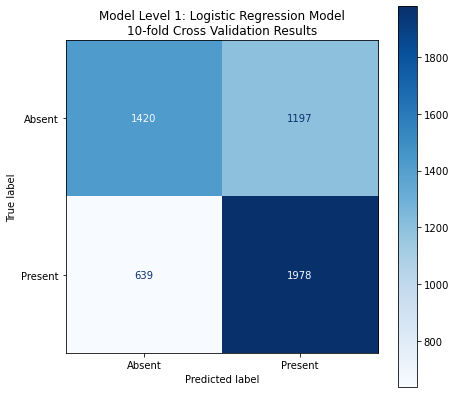

In [29]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the balanced rate of false positives and false negatives that we saw in the in-sample performance. 

### Preparing submission file

In [37]:
test_file = pd.read_csv(data_path+'test_data/level_1/test.csv')

In [38]:
test_regions = [
    {'title':"Greater Sydney, Australia", 
     'bbox':(150.25, -33.75, 150.75, -33.25)}
]

In [39]:
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
    region['result'] = predict_frogs(weather_data, full_model) > 0.5
    display(region['result'])
    
    

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


<xarray.DataArray (y: 512, x: 512)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) float64 -34.25 -34.25 -34.25 -34.24 ... -33.25 -33.25 -33.25
  * x        (x) float64 150.2 150.2 150.2 150.2 ... 151.1 151.1 151.1 151.2

In [40]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="key", coords={"key": region['coords'].index}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="key", coords={"key": region['coords'].index}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .drop('key', 1)
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[2::]})
)

submission.to_csv(storage_path+'submission.csv', index=None)

### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a species different to litoria fallax, or on a region different to Greater Sydney. A more challenging exercise would be to train a model capable of predicting each species simultaneously, so that your model can predict the relative likelihood of finding each species at any given pixel on the map. 

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method of predicting one species against the rest was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitats of the species of interest. Happy frogging!